# TEAM 11 CLASSIFICATION: CLIMATE CHANGE TWEET SENTIMENT ANALYSIS

In [8]:
#Installing the comet library for version control
!pip install comet_ml

We start by importing Comet and starting an experiment in Comet so that we can save the different experiments and models we run.This is for effective version control.

In [9]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="QTucqdVPpqdILbXpZnSCKY6vP",
    project_name="unsupervised-classification-predict",
    workspace="euphrasiam",
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/euphrasiam/unsupervised-classification-predict/f10073d147954e17b323635666175236
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (15.28 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/euphrasiam/unsupervised-classification-predict/85ca

**Importing the packages needed for data engineering **

In [10]:
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

import re
import re
import nltk
import itertools
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# Importing our data i.e cvs files

In [11]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pathlib import Path
data = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data[filename] = Path(dirname) / filename

# Any results you write to the current directory are saved as output.
data

{}

In [12]:
from IPython.display import (
    Markdown as md,
    Latex,
    HTML,
)
from tqdm.auto import tqdm

In [13]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

tweets = pd.read_csv("train.csv")

test_data = pd.read_csv("test_with_no_labels.csv")

tweets.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


We see here that our train data set has 3 columns, the tweetid, the message and the sentiment observed

# EDA (Exploratory Data Analysis)


We're going to start an Exploratory Data Analysis (EDA). The first step of any Machine Learning project is to develop an understanding of your data, as that will help with model selection later on.

In [14]:
#display the shape of our dataframe created from out train dataset
display(tweets.shape)

(15819, 3)

We note here that our datframe has 3 columns and 15819 rows

In [15]:
#checking the value counts for the sentiment row
value_counts = tweets["sentiment"].value_counts()
value_counts.name = "Raw Number"

value_normd = tweets["sentiment"].value_counts(normalize=True)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))

,Raw Number,Percentage
1,8530,0.539225
2,3640,0.230103
0,2353,0.148745
-1,1296,0.081927


We note here above what percentage of our sampled data is allocated to each sentiment. Like 1 being 53%,2 23% etc

Another important thing to note when doing any data engineering and modelling would be the datatypes

In [16]:
#view datatype
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


Our sentiment and tweetid columns are of numeric type while the message is of object type

Let's make a copy of the pd.DataFrame so we can feed tweets into our models later.

In [17]:
from copy import deepcopy
eda = deepcopy(tweets)

Here we replace the numeral values for sentiment with text so as to make our analysis easier to understand

In [18]:
sentiment_num2name = {
    -1: "Anti",
     0: "Neutral",
     1: "Pro",
     2: "News",
}
eda["sentiment"] = eda["sentiment"].apply(lambda num: sentiment_num2name[num])
eda.head()

,sentiment,message,tweetid
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Pro,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Graphically visualize how the sentiment is distributed in the data

In [19]:
sns.set(font_scale=1.5) #setting font types and which style we want to use
style.use("seaborn-poster")

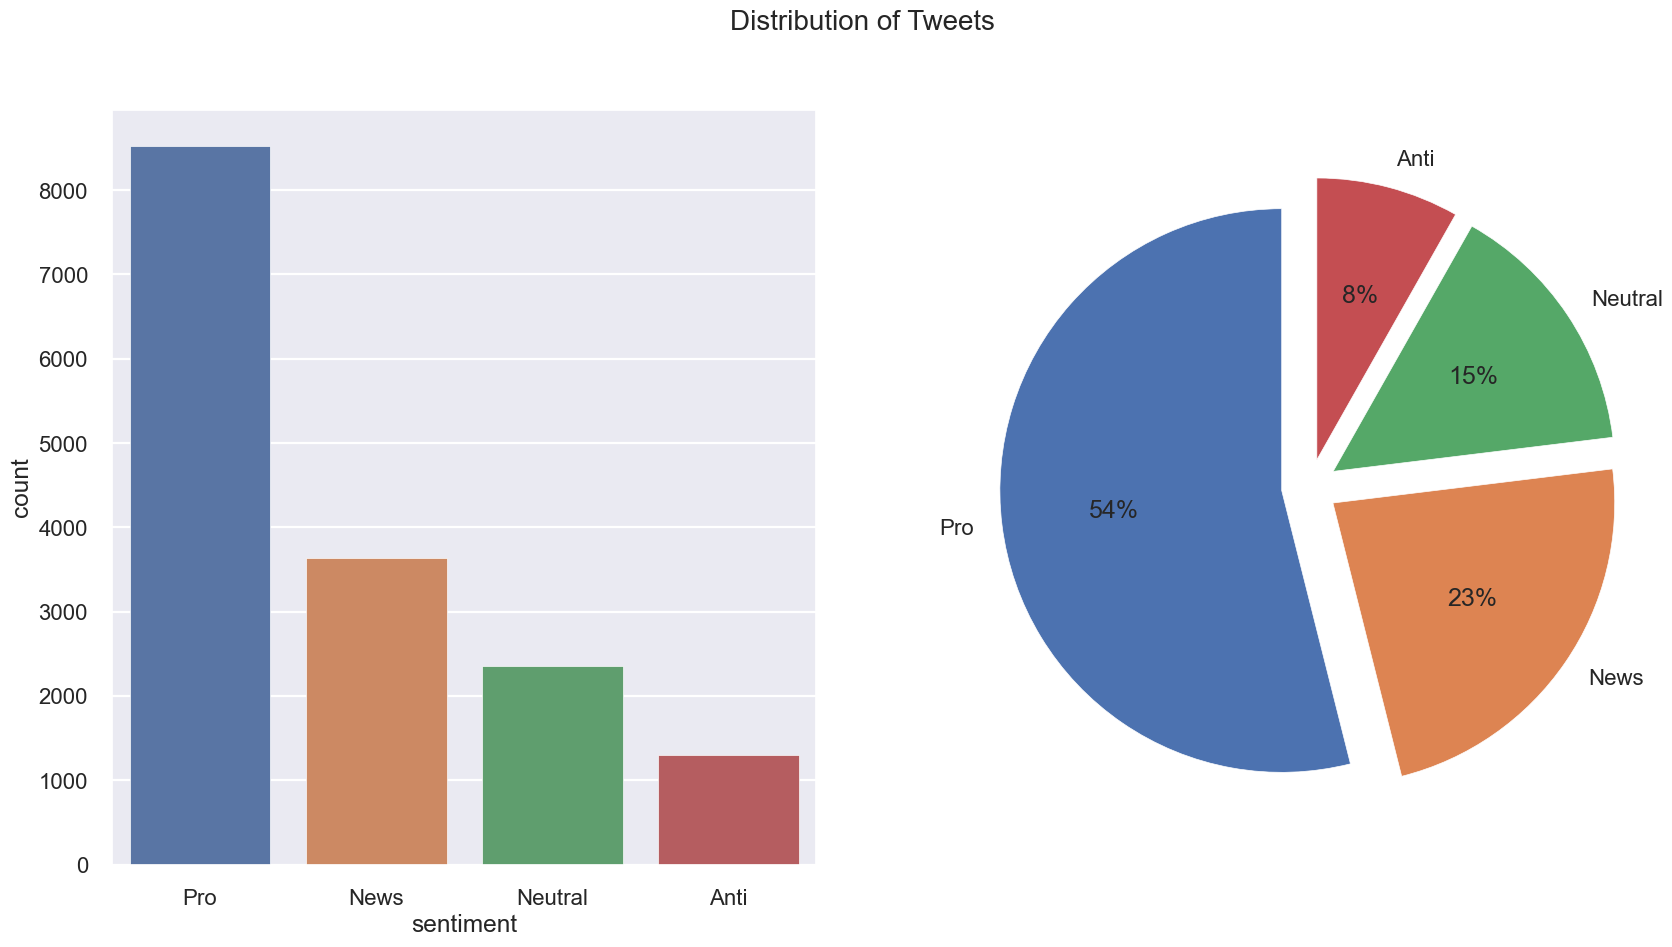

In [20]:
#plotting our data in a pie chart and bar graph
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=100)

sns.countplot(eda["sentiment"], ax=axes[0])
labels = list(sentiment_num2name.values())

axes[1].pie(eda["sentiment"].value_counts(),
            labels=['Pro','News','Neutral','Anti'],
            autopct="%1.0f%%",
            startangle=90,
            explode=tuple([0.1] * len(labels)))

fig.suptitle("Distribution of Tweets", fontsize=20)
plt.show()

What we see here graphically is what the table abpve depicted, which is that the pro climate change sentiment is the highest, followed by the news then the neutral an lastly the Anti climate cnahge sentiment.

What we look into next is creating a table that will show us the top 15 hashtags for each sentiment class.This may give us a better idea about the sentiments people have just from seeing their hashtags

In [21]:
top15 = {}

by_sentiment = eda.groupby("sentiment")
for sentiment, group in tqdm(by_sentiment):
    hashtags = group["message"].apply(lambda tweet: re.findall(r"#(\w+)", tweet))
    hashtags = itertools.chain(*hashtags)
    hashtags = [ht.lower() for ht in hashtags]
    
    frequency = nltk.FreqDist(hashtags)
    
    df_hashtags = pd.DataFrame({
        "hashtags": list(frequency.keys()),
        "counts": list(frequency.values()),
    })
    top15_htags = df_hashtags.nlargest(15, columns=["counts"])
    
    top15[sentiment] = top15_htags.reset_index(drop=True)

display(pd.concat(top15, axis=1).head(n=10))

100%|██████████| 4/4 [00:00<00:00, 32.92it/s]


Anti                Neutral                     News         \
         hashtags counts        hashtags counts          hashtags counts   
0            maga     14         climate     19           climate    135   
1         climate     10   climatechange     15     climatechange     65   
2           trump      8           trump     12       environment     47   
3   climatechange      8  beforetheflood      5              news     32   
4   globalwarming      5           qanda      4             trump     25   
5        fakenews      4       amreading      4           science     18   
6    opchemtrails      4           cop22      4                p2     14   
7            tcot      4   globalwarming      3  greatbarrierreef     14   
8  parisagreement      4     parisaccord      3             cop22     14   
9           qanda      3   climatecounts      3    parisagreement      9   

               Pro         
          hashtags counts  
0          climate    188  
1   beforetheflood    148  
2    climatechange    120  
3  imvotingbecause     62  
4            cop22     59  
5   parisagreement     52  
6     actonclimate     49  
7            trump     43  
8                ã     37  
9    globalwarming     35

You will notice that the most commond hastags revolve around the Trump campaign, voting and climate change policy. This tells us that this dataset was sampled from during campiagn times

**Anti**:From here we pick up various hastags that actually makes sense for the sentiment they represent.For instance under the Anti columns we have hashtags like mada(Make America Great Again) which the slogan that Donald Trump used in his campaign and we know that Trump was very anti-climate change.We also have fakenews as a trending hashtag under Anti as Trump and his supporters used that statement alot when trying to nullify anything in the news they did not agree with. More so global warming and climate change.Another interesting one is "opchemtrails" one; this refers to operation chemtrails, a conspiracy theory that anti climate change activists believe that heads of States are lacing our atmosphere with harmful gasses so that they can advance the climate change narrative

**Pro**: The pro sentiment has trending hastags like beforetheflood(A movie about climate change and the global action needed to fight it.Another one that stands out is Cop22(The 2016 UN climate change conference held in Morocco where they discussed various enviromental issues) and also parisagreement(is an international treaty on climate change, adopted in 2015. It covers climate change mitigation, adaptation, and finance).These 2 a big reference point for people who believe in climate change.

**News** The news columns hashtags cover cop22 and the greatbarrierreefs, mainly because 2016 included headlines like "Extreme heat in 2016 damaged Australia's Great Barrier Reef much more substantially than initial surveys indicated" which also informed trends in other sentiment classes

**Neutral** Some interesting hashtags that stand out for us are "qanda" and "amreading" hastags that makes sense for the neutral sentiment which show that this is mainly people who are neutral and doing their research on the issues. Also the other hastags represent bothe the pro and anti sentiment classes.

We now want to look at the popularity of these hashtags visually per the sentiment classes

In [22]:
#fig, axes = plt.subplots(2, 2, figsize=(eda["message"].apply(cleaner), 20))

In [23]:
#fig, axes = plt.subplots(2, 2, figsize=(eda["message"] = eda["message"].apply(cleaner),eda.head()28, 20))
#counter = 0

#for sentiment, top in top15.items():
   # sns.barplot(data=top, y="hashtags", x="counts", palette="Blues_d", ax=axes[counter // 2, counter % 2])
   # axes[counter // 2, counter % 2].set_title(f"Most frequent Hashtags by {sentiment} (Visually)", fontsize=25)
   # counter += 1
#plt.show()

# Data Engineering

In [24]:
#This function is meant to remove all the noise in the tweets so that we can be able 
#to strictly analyse the words in the tweets against our target variable
def cleaner(tweet):
    tweet = tweet.lower()
    
    to_del = [
        r"@[\w]*",  # strip account mentions
        r"http(s?):\/\/.*\/\w*",  # strip URLs
        r"#\w*",  # strip hashtags
        r"\d+",  # delete numeric values
        r"rt[\s]+",
        r"U+FFFD",  # remove the "character note present" diamond
    ]
    for key in to_del:
        tweet = re.sub(key, "", tweet)
    
    # strip punctuation and special characters
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", tweet)
    # strip excess white-space
    tweet = re.sub(r"\s\s+", " ", tweet)
    
    return tweet.lstrip(" ")

In [25]:
#We apply our cleaner function to the eda dataframe that we copied
eda["message"] = eda["message"].apply(cleaner)
eda.head()

,sentiment,message,tweetid
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221
1,Pro,it s not like we lack evidence of anthropogeni...,126103
2,News,researchers say we have three years to act on ...,698562
3,Pro,wired was a pivotal year in the war on climate...,573736
4,Pro,it s and a racist sexist climate change denyin...,466954


As you can see all the punctiation,caps and extra spaces are gone and we just have plain text that we can analyze

In [26]:
# Importing some libraries for NLP data engineering the text

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  

In [27]:
#Function to lammatize the data frame
#This function also tokenizes and gives us the different parts of speech for the words

def lemmatizer(df):
    df["length"] = df["message"].str.len()
    df["tokenized"] = df["message"].apply(word_tokenize)
    df["parts-of-speech"] = df["tokenized"].apply(nltk.tag.pos_tag)
    
    def str2wordnet(tag):
        conversion = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}
        try:
            return conversion[tag[0].upper()]
        except KeyError:
            return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    df["parts-of-speech"] = df["parts-of-speech"].apply(
        lambda tokens: [(word, str2wordnet(tag)) for word, tag in tokens]
    )
    df["lemmatized"] = df["parts-of-speech"].apply(
        lambda tokens: [wnl.lemmatize(word, tag) for word, tag in tokens]
    )
    df["lemmatized"] = df["lemmatized"].apply(lambda tokens: " ".join(map(str, tokens)))
    
    return df

In [28]:
#lemmatize the eda dataframe
eda = lemmatizer(eda)
eda.head()

,sentiment,message,tweetid,length,tokenized,parts-of-speech,lemmatized
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221,102,"[polyscimajor, epa, chief, doesn, t, think, ca...","[(polyscimajor, a), (epa, n), (chief, n), (doe...",polyscimajor epa chief doesn t think carbon di...
1,Pro,it s not like we lack evidence of anthropogeni...,126103,62,"[it, s, not, like, we, lack, evidence, of, ant...","[(it, n), (s, v), (not, r), (like, n), (we, n)...",it s not like we lack evidence of anthropogeni...
2,News,researchers say we have three years to act on ...,698562,83,"[researchers, say, we, have, three, years, to,...","[(researchers, n), (say, v), (we, n), (have, v...",researcher say we have three year to act on cl...
3,Pro,wired was a pivotal year in the war on climate...,573736,54,"[wired, was, a, pivotal, year, in, the, war, o...","[(wired, v), (was, v), (a, n), (pivotal, a), (...",wire be a pivotal year in the war on climate c...
4,Pro,it s and a racist sexist climate change denyin...,466954,78,"[it, s, and, a, racist, sexist, climate, chang...","[(it, n), (s, v), (and, n), (a, n), (racist, n...",it s and a racist sexist climate change deny b...


# More EDA: buzzwords

In [29]:
#Checking what the buzzwords are, that is the words that show up the most in the tweets.
#We use countvectorizer to remove English stop words 
frequency = {}

by_sentiment = eda.groupby("sentiment")
for sentiment, group in tqdm(by_sentiment):
    cv = CountVectorizer(stop_words="english")
    words = cv.fit_transform(group["lemmatized"])
    
    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    
    frequency[sentiment] = freq.head(n=25)

to_view = pd.concat(frequency, axis=1).head(n=25)
display(to_view)

100%|██████████| 4/4 [00:00<00:00, 10.91it/s]


Anti       Neutral             News              Pro      
         word freq     word  freq       word  freq       word  freq
0     climate  797  climate  1428     change  3264     change  7249
1      change  786   change  1419    climate  3209    climate  7195
2      global  638   global  1038      trump  1029     global  1603
3     warming  488  warming   860     global   509    warming  1196
4        warm  134     warm   169    warming   345    believe  1113
5        make  109    trump   169        say   329      trump  1051
6         man   95      say   141        epa   254      think   808
7         amp   91    think   121  scientist   214      doesn   709
8     science   80    cause   113        new   192        amp   695
9       cause   73      amp   112      fight   186       real   518
10        say   69  believe   104     donald   165      world   491
11       just   68     like   102      world   156        say   480
12       real   65     real    99      china   156     people   467
13  scientist   64     just    94      obama   130        die   418
14       year   64  penguin    86  president   120  president   409
15      trump   62     know    71     pruitt   118      fight   395
16     people   58   people    69       plan   113     denier   376
17    believe   58     make    69      scott   112       just   372
18       scam   54     talk    68      paris   107        don   364
19        tax   51      don    68      study   102       http   357
20       hoax   51     tell    66      chief   102       make   321
21       data   50      ask    59     energy   102       like   318
22    liberal   48      hot    53       warm    99       warm   313
23       fake   47     come    51        use    95    husband   312
24      obama   45      isn    51       news    95      right   293

Now that we have computed the frequencies of these buzzwords we use Word clouds to visually see what is happening with these word frequencies

100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


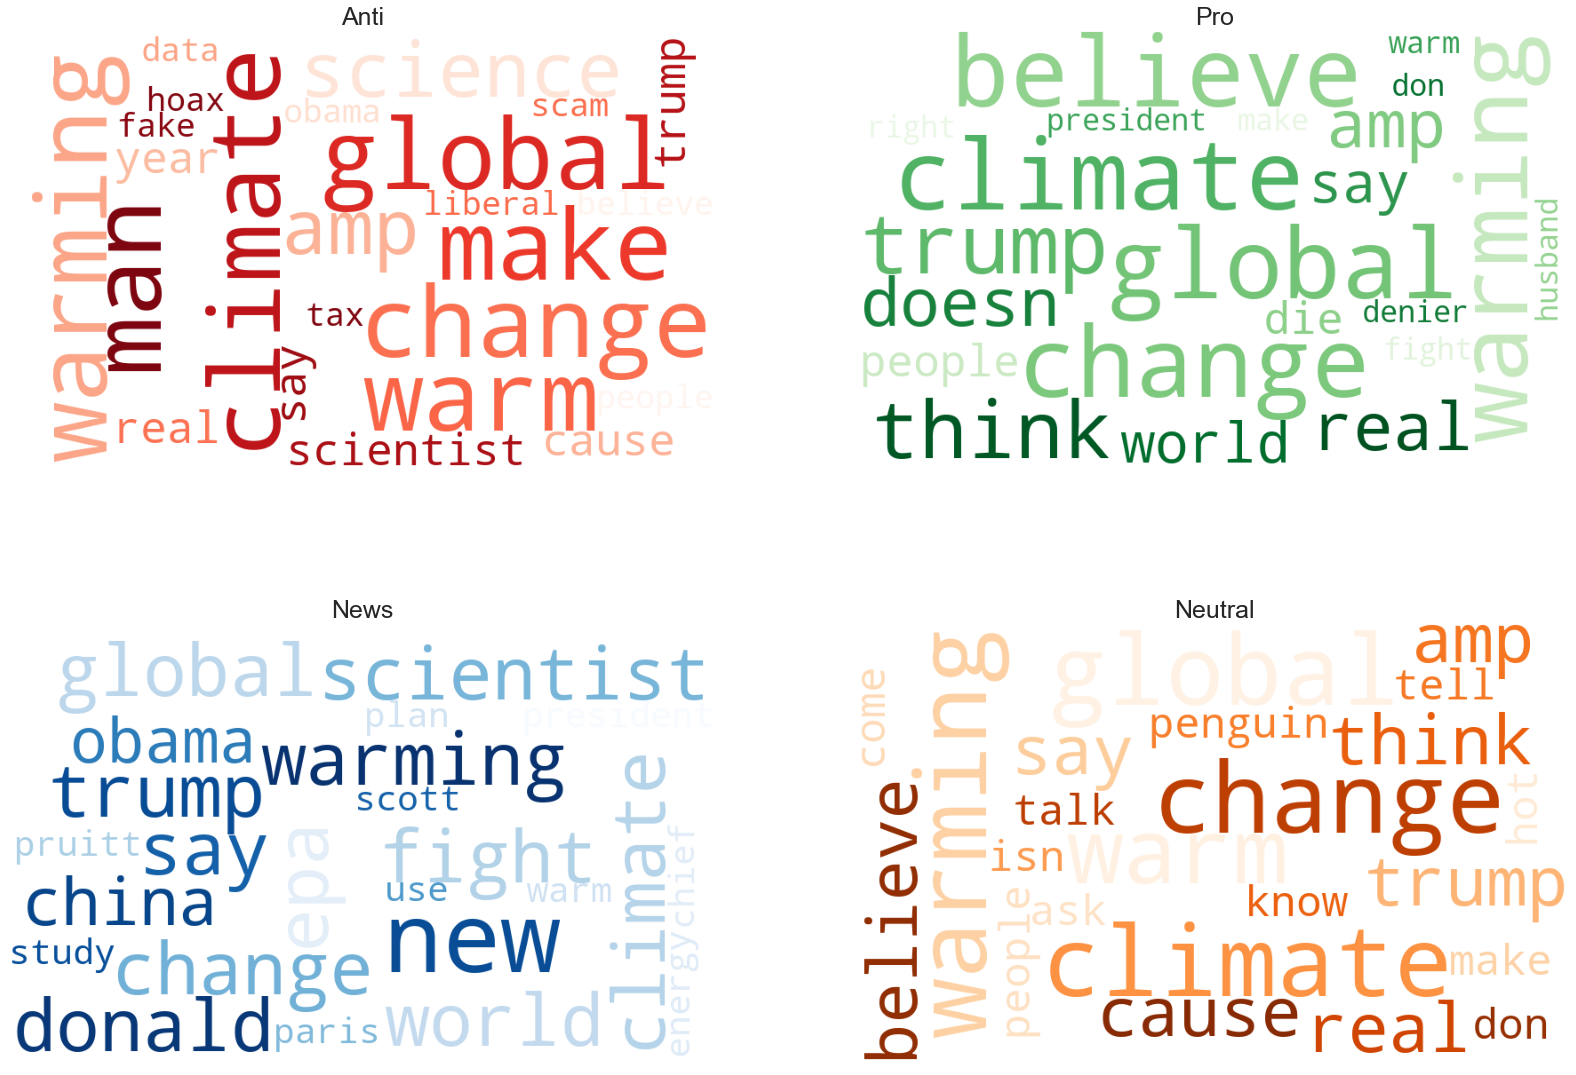

In [33]:

words = {sentiment: " ".join(frequency[sentiment]["word"].values) for sentiment in sentiment_num2name.values()}

cmaps = {
    "Anti": ("Reds", 110),
    "Pro" : ("Greens", 73),
    "News": ("Blues", 0),
    "Neutral": ("Oranges", 10),
}

from wordcloud import WordCloud

wordclouds = {}
for sentiment, (cmap, rand) in tqdm(cmaps.items()):
    wordclouds[sentiment] = WordCloud(
        width=800, height=500, random_state=rand,
        max_font_size=110, background_color="white",
        colormap=cmap
    ).generate(words[sentiment])
    
fig, axes = plt.subplots(2, 2, figsize=(28, 20))
counter = 0

for sentiment, wordcloud in wordclouds.items():
    axes[counter // 2, counter % 2].imshow(wordcloud)
    axes[counter // 2, counter % 2].set_title(sentiment, fontsize=25)
    counter += 1
    
for ax in fig.axes:
    plt.sca(ax)
    plt.axis("off")

plt.show()

* Words like science ,data and scientist are occuring alot under Anti, which could indicate that they either believe they are quoting research or could mean they are quite against the opinions shared by scientists. Other interesting words coming out from the Anti wordcloud are scam,fake, tax and hoax which speak to the core arguments of this sentiment.That the climate change movement is meant to raise taxes and that it is a scam
* Words like Climate, Change, global, trump are common for all the word clouds and this could be because this is the subject matter of all the sentiments
* The news word cloud has words that point towards current affairs like the paris agreement, moving from Obama to Trump administration,the EPA and Pruitt(Environmental Protection Agency Administrator Scott Pruitt)
* Words like believe, think,cause,real speak to how strongly the pro sentiment class belive in the climate change movement and that perhaps those who don't are not 'thinking'

# Modelling

In [34]:
# Application of the function to clean the tweets in the train and test datasets
tweets['message'] = tweets['message'].apply(cleaner)
test_data['message'] = test_data['message'].apply(cleaner)

In [35]:
#Apply the lemmatizer function to the test and train dataset before modelling
tweets = lemmatizer(tweets)
test_data = lemmatizer(test_data)

In [36]:
#separate the target and feature variables
X = tweets['message']
y = tweets['sentiment']

In [37]:
#Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

In [40]:
# Importing Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import xgboost as xgb


from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

import time

# Model Evaluation Packages
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
%matplotlib inline

THE FIVE DIFFERENT MODELS WE TRY OUT ARE:
1. Linear SVC Model
2. Logistics Regression
3. K Neighbours Classifier
4. Multinomial Naive Bayers
5. SGD classifier
6. Complement Naive Bayers classifier

1. LINEAR SVC MODEL

In [41]:
#linear SVC model
Lsvc=LinearSVC(random_state=42)
#fit the model
clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', Lsvc)])

        # Logging the Execution Time for each model
start_time = time.time()
clf_text.fit(X_train, y_train)
run_time = time.time()-start_time

Lsvc_pred = clf_text.predict(X_val)

In [63]:
import pickle

model_save_path = "LinearSVC.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf_text,file)

In [42]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,Lsvc_pred,average='macro')
F1_Accuracy=f1_score(y_val, Lsvc_pred,average='micro')
F1_Weighted=f1_score(y_val,Lsvc_pred,average='weighted')
Execution_Time=run_time

In [43]:
#Creating dictionaries for the data you want to log
params={"Random state":42,
       "Model_type": "LinearSVC",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params) #logging metrics for experiment
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

2. LOGISTIC REGRESSION

In [44]:
lr=LogisticRegression(random_state=42,
                                  multi_class='ovr',
                                  n_jobs=1,
                                  C=1e5,
                                  max_iter=4000)
#fit the model
clf_lr = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', lr)])

        # Logging the Execution Time for each model
start_time = time.time()
clf_lr.fit(X_train, y_train)
run_time = time.time()-start_time

lr_pred = clf_lr.predict(X_val)

In [64]:
model_save_path = "LogisticRegression.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf_lr,file)

In [45]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,lr_pred,average='macro')
F1_Accuracy=f1_score(y_val, lr_pred,average='micro')
F1_Weighted=f1_score(y_val,lr_pred,average='weighted')
Execution_Time=run_time

In [46]:
#Creating dictionaries for the data you want to log
params={"Random state":42,
       "Model_type": "Logistic Regression",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params) #logging metrics for experiment
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

3. K NEIGHBOURS CLASSIFIER

In [47]:
kn=KNeighborsClassifier(n_neighbors=5)
#fit the model
clf_kn = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', kn)])

# Logging the Execution Time for each model
start_time = time.time()
clf_kn.fit(X_train, y_train)
run_time = time.time()-start_time

kn_pred = clf_kn.predict(X_val)

In [65]:
model_save_path = "KNeighbours.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf_kn,file)

In [48]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,kn_pred,average='macro')
F1_Accuracy=f1_score(y_val, kn_pred,average='micro')
F1_Weighted=f1_score(y_val,kn_pred,average='weighted')
Execution_Time=run_time

In [49]:
#Creating dictionaries for the data you want to log
params={"Random state":42,
       "Model_type": "K-Neighbours",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params) #logging metrics for experiment
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

4. MULTINOMIAL NB

In [50]:
mnb=MultinomialNB()
#fit the model
clf_mnb = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', mnb)])

# Logging the Execution Time for each model
start_time = time.time()
clf_mnb.fit(X_train, y_train)
run_time = time.time()-start_time

mnb_pred = clf_mnb.predict(X_val)

In [66]:
model_save_path = "MultinomialNB.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf_mnb,file)

In [51]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,mnb_pred,average='macro')
F1_Accuracy=f1_score(y_val, mnb_pred,average='micro')
F1_Weighted=f1_score(y_val,mnb_pred,average='weighted')
Execution_Time=run_time

In [52]:
#Creating dictionaries for the data you want to log
params={"Random state":"default",
       "Model_type": "Multinomial",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params)
experiment.log_metrics(metrics) #logging metrics for experiment

In [ ]:
experiment.end() # ending the comet experiment

5. SGD CLASSIFIER

In [54]:
sgd=SGDClassifier(loss='hinge',penalty='l2',
                             alpha=1e-3,
                             random_state=42,
                             max_iter=5,
                             tol=None)
#fit the model
clf_sgd = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', sgd)])

# Logging the Execution Time for each model
start_time = time.time()
clf_sgd.fit(X_train, y_train)
run_time = time.time()-start_time

sdg_pred = clf_sgd.predict(X_val)

In [67]:
model_save_path = "SGDClassifier.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf_sgd,file)

In [55]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,mnb_pred,average='macro')
F1_Accuracy=f1_score(y_val, mnb_pred,average='micro')
F1_Weighted=f1_score(y_val,mnb_pred,average='weighted')
Execution_Time=run_time

In [56]:
#Creating dictionaries for the data you want to log
params={"Random state":"default",
       "Model_type": "Multinomial",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params) #logging metrics for experiment
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

6.COMPLEMENT NB CLASSIFIER

In [58]:
cn=ComplementNB()
#fit the model
clf_sgd = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                               max_df=0.9,
                                               ngram_range=(1, 2))),
                     ('clf', sgd)])

# Logging the Execution Time for each model
start_time = time.time()
clf_sgd.fit(X_train, y_train)
run_time = time.time()-start_time

sdg_pred = clf_sgd.predict(X_val)

In [59]:
#saving each metric to a dictionary for logging
F1_Macro=f1_score(y_val,mnb_pred,average='macro')
F1_Accuracy=f1_score(y_val, mnb_pred,average='micro')
F1_Weighted=f1_score(y_val,mnb_pred,average='weighted')
Execution_Time=run_time

In [60]:
#Creating dictionaries for the data you want to log
params={"Random state":"default",
       "Model_type": "Multinomial",
       }

metrics={"F1_Macro":F1_Macro,
"F1_Accuracy":F1_Accuracy,
"F1_Weighted":F1_Weighted,
"Execution_Time":Execution_Time
    
}

In [ ]:
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end() #ending the comet experiment

In [61]:
# Refining the train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)

Finally based on performance of the models we choose the Multinomial Naive Bias classifier and we predict the data of the validation set which we separated.

In [62]:
# Creating a pipeline for the gridsearch
param_grid = {'alpha': [0.1, 1, 5, 10]}  # setting parameter grid

tuned_mnb = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.9,
                                                ngram_range=(1, 2))),
                      ('mnb', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_weighted'))
                      ])

tuned_mnb.fit(X_train, y_train)  # Fitting the model

y_pred_mnb = tuned_mnb.predict(X_val)  # predicting the fit on validation set

print(classification_report(y_val, y_pred_mnb))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         9
           0       0.62      0.28      0.38        29
           1       0.66      0.90      0.76        77
           2       0.79      0.70      0.75        44

    accuracy                           0.68       159
   macro avg       0.52      0.47      0.47       159
weighted avg       0.65      0.68      0.64       159



# Predicting sentiment for our test data and produce csv to submit to Kaggle

In [ ]:
submission_df = pd.DataFrame(test_data['tweetid'])
submission_df['sentiment'] = tuned_mnb.predict(test_data['message'])
submission_df.to_csv('submission4.csv', index=False)